
### Prediction based anomaly detection


This is a slightly modified clone of the Kyle Hundman's github repo [telemanom](https://github.com/khundman/telemanom).
See also the article [Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding](https://www.groundai.com/project/detecting-spacecraft-anomalies-using-lstms-and-nonparametric-dynamic-thresholding/#bib.bib14) in groundai.com.

The approach has two components, an LSTM-NN for prediction and a sophisticated thresholding approach to actually detect anomalies. (The authors compared their approach with Gaussian Tail approaches such as z-score in one dimension or elliptic envelopes for multiple dimensions and showed their approach yields better results.)

The LSTM part is quite similar to the approach chosen for [LSTM Neural Networks for Anomaly Detection](https://medium.com/datadriveninvestor/lstm-neural-networks-for-anomaly-detection-4328cb9b6e27)


In [1]:
import os
import logging
import threading
import pandas as pd  
import math
import dill
import numpy as np  
import matplotlib.pyplot as plt
import pydot
import seaborn as seabornInstance
import networkx
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import anomaly
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator, ui, base, bif
from iotfunctions.base import BaseTransformer
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.enginelog import EngineLogging
from iotfunctions import pipeline as pp
from iotfunctions.stages import DataWriterSqlAlchemy, DataWriterFile
from iotfunctions.pipeline import JobController, DataAggregator

import datetime as dt
from scipy.linalg import norm
import scipy as sp
from scipy import signal
from scipy import linalg
from pyod.models.cblof import CBLOF
from pyod.models.ocsvm import OCSVM
from pyod.models.xgbod import XGBOD

#import pmdarima as pm
import inverse_covariance as icov # from package skggm
from inverse_covariance import QuicGraphLasso

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from skimage import util as skiutil # for nifty windowing

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from keras.models import Sequential
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import LSTM, Dense, Flatten, Input, Dropout, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate
from keras.utils import plot_model
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from keras.utils import model_to_dot
import telemanom
from telemanom.helpers import Config
from telemanom.errors import Errors
import telemanom.helpers as helpers
from telemanom.channel import Channel
from telemanom.modeling import Model

%matplotlib inline

/home/markus/.local/lib/python3.7/site-packages/iotfunctions/bif.py:1605: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'
/home/markus/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/markus/.local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised wh

In [2]:
# load original data set
#!curl -O https://s3-us-west-2.amazonaws.com/telemanom/data.zip && unzip data.zip -d telemanom && rm data.zip
!mkdir -p ./telemanom/data/2020-01-29_15.00.10/data

In [3]:
# set up the default model parameters
# hidden layers 	2
# units in hidden layers 	80
# sequence length (ls) 	250
# training iterations 	30
# dropout 	0.3
# batch size 	64
# optimizer 	Adam
logger = helpers.setup_logging()
logger.setLevel(logging.DEBUG)
conf = Config("/home/markus/src/mmfunctions/telemanom/config.yaml")

In [4]:
# Load data from 
device="E-3"
chan = Channel(conf, device)
helpers.make_dirs(conf.use_id, conf, "./telemanom")

In [5]:
chan.load_data("./telemanom")
# chan.train
df2 = pd.DataFrame(chan.train)
df2

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.247183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.247183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.247183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.247183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.247183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,0.086224,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2876,0.169473,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2877,0.169473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2878,0.169473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
df2.describe()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
count,2880.000000,2880.000000,2880.000000,2880.000000,2880.0,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,...,2880.0,2880.0,2880.000000,2880.000000,2880.000000,2880.0,2880.000000,2880.000000,2880.0,2880.0
mean,0.133693,0.036806,0.006944,0.029167,0.0,0.170486,0.131944,0.001389,0.000694,0.000694,...,0.0,0.0,0.029167,0.029167,0.014583,0.0,0.038542,0.037500,0.0,0.0
std,0.417045,0.188317,0.083058,0.168303,0.0,0.376125,0.338489,0.037248,0.026348,0.026348,...,0.0,0.0,0.168303,0.168303,0.119899,0.0,0.192533,0.190017,0.0,0.0
min,-1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
25%,-0.163768,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
50%,0.086224,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
75%,0.502095,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,0.0


In [6]:
# split training data into windows of size 260: 
#   lookback aka l_s (defined in config.yaml as 250) + n_predictions (defined in config.yaml as 10)
#   to predict the last 10 data points from the past 250 ones
#   this is quite similar to our windowsize parameter !
chan.shape_data(chan.train, train=True)

In [7]:
print(chan)


Channel:Channel
Training data shape: (2620, 250, 25), (2620, 10)
  Test data shape: (8047, 250, 25), (8047, 10)
  Original data shape: (2880, 25), (8307, 25)


In [14]:
# T-9,MSL,"[[780, 810], [890, 970]]","[point, point]",1096
model = Model(conf, conf.use_id, chan, "./telemanom", False)

In [15]:
model.train_new(chan)

Train on 2096 samples, validate on 524 samples
Epoch 1/35
2096/2096 [==============================] - 8s 4ms/step - loss: 0.0773 - val_loss: 0.0186
Epoch 2/35
2096/2096 [==============================] - 8s 4ms/step - loss: 0.0203 - val_loss: 0.0092
Epoch 3/35
2096/2096 [==============================] - 8s 4ms/step - loss: 0.0131 - val_loss: 0.0059
Epoch 4/35
2096/2096 [==============================] - 8s 4ms/step - loss: 0.0115 - val_loss: 0.0056
Epoch 5/35
2096/2096 [==============================] - 8s 4ms/step - loss: 0.0097 - val_loss: 0.0043
Epoch 6/35
2096/2096 [==============================] - 8s 4ms/step - loss: 0.0086 - val_loss: 0.0030
Epoch 7/35
2096/2096 [==============================] - 8s 4ms/step - loss: 0.0077 - val_loss: 0.0030
Epoch 8/35
2096/2096 [==============================] - 8s 4ms/step - loss: 0.0071 - val_loss: 0.0031
Epoch 9/35
2096/2096 [==============================] - 8s 4ms/step - loss: 0.0071 - val_loss: 0.0028
Epoch 10/35
2096/2096 [============

In [16]:
print (model)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, None, 80)          33920     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 80)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_6 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                810       
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 86,250
Trainable params: 86,250
Non-trainable params: 0
__________________________________________________

In [17]:
df = pd.DataFrame(chan.X_train[0])
df.describe()
# P-10,MSL,"[[4590, 4720]]",[point],6100
#df.iloc[2750:2800]

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
count,250.000000,250.000000,250.0,250.000000,250.0,250.000000,250.000000,250.0,250.0,250.0,...,250.0,250.0,250.000000,250.000000,250.000000,250.0,250.000000,250.000000,250.0,250.0
mean,0.295121,0.024000,0.0,0.024000,0.0,0.148000,0.116000,0.0,0.0,0.0,...,0.0,0.0,0.024000,0.024000,0.012000,0.0,0.028000,0.028000,0.0,0.0
std,0.238559,0.153356,0.0,0.153356,0.0,0.355812,0.320867,0.0,0.0,0.0,...,0.0,0.0,0.153356,0.153356,0.109104,0.0,0.165304,0.165304,0.0,0.0
min,-0.080396,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
25%,0.086224,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
50%,0.335858,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
75%,0.502095,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
max,0.834159,1.000000,0.0,1.000000,0.0,1.000000,1.000000,0.0,0.0,0.0,...,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,0.0


In [24]:
model.save("./telemanom")

In [18]:
# print (chan.X_train)
model.batch_predict(chan, Path="./telemanom")
# predict test data batch-wise and append the results

In [27]:
print (chan.y_hat.shape, chan.y_test.shape)

(8047,) (8047, 10)


In [21]:
# smooth the prediction error and apply exponential weights to it
errors = Errors(chan, conf, conf.use_id, "./telemanom")

#  for each overlapping window establish a threshold so that removing error points above it 
# maximizes the reduction of mean and standard deviation. Sort of an adaptive z-score 
errors.process_batches(chan)

normalized prediction error: 0.02


In [28]:
print (errors.E_seq, " \n ", errors.anom_scores)

[(5570, 5709)]  
  [{'start_idx': 5320, 'end_idx': 5389, 'score': 3.504268339986817}, {'start_idx': 5390, 'end_idx': 5459, 'score': 3.7353472227877074}]


### Real life data

Now we try with real life data, just copy the pump data from the internal github into the telemanom subfolder and 
run the next steps in sequence.

We attempt to spot anomalies in `raw_vibrations_x0`, incidentally the first non-array, non-timestamp column of the pump dataset. I'm simply stripping away timestamps, arrays and any vibration related column but the first.

In [118]:
df_good = pd.read_csv('telemanom/normal_pumps.csv', parse_dates=['RCV_TIMESTAMP_UTC'])
df_bad = pd.read_csv('telemanom/fault_pumps.csv', parse_dates=['RCV_TIMESTAMP_UTC'])
df_ugly = pd.read_csv('telemanom/test_pumps.csv', parse_dates=['RCV_TIMESTAMP_UTC'])

print (df_good.shape, df_bad.shape, df_ugly.shape)

# full list of column names for further reference (aka copy-and-paste)
list_attr = ['raw_vibrations_x_0',
       'raw_vibrations_x_1', 'raw_vibrations_x_2', 'raw_vibrations_x_3',
       'raw_vibrations_x_4', 'raw_vibrations_x_5', 'raw_vibrations_x_6',
       'raw_vibrations_x_7', 'raw_vibrations_x_8', 'raw_vibrations_x_9',
       'raw_vibrations_x_10', 'raw_vibrations_x_11', 'raw_vibrations_x_12',
       'raw_vibrations_x_13', 'raw_vibrations_x_14', 'raw_vibrations_y_0',
       'raw_vibrations_y_1', 'raw_vibrations_y_2', 'raw_vibrations_y_3',
       'raw_vibrations_y_4', 'raw_vibrations_y_5', 'raw_vibrations_y_6',
       'raw_vibrations_y_7', 'raw_vibrations_y_8', 'raw_vibrations_y_9',
       'raw_vibrations_y_10', 'raw_vibrations_y_11', 'raw_vibrations_y_12',
       'raw_vibrations_y_13', 'raw_vibrations_y_14', 'raw_vibrations_z_0',
       'raw_vibrations_z_1', 'raw_vibrations_z_2', 'raw_vibrations_z_3',
       'raw_vibrations_z_4', 'raw_vibrations_z_5', 'raw_vibrations_z_6',
       'raw_vibrations_z_7', 'raw_vibrations_z_8', 'raw_vibrations_z_9',
       'raw_vibrations_z_10', 'raw_vibrations_z_11', 'raw_vibrations_z_12',
       'raw_vibrations_z_13', 'raw_vibrations_z_14', 'rms_x_0', 'rms_x_1',
       'rms_x_2', 'rms_x_3', 'rms_x_4', 'rms_y_0', 'rms_y_1', 'rms_y_2',
       'rms_y_3', 'rms_y_4', 'rms_z_0', 'rms_z_1', 'rms_z_2', 'rms_z_3',
       'rms_z_4', 'accel_speed_0', 'accel_speed_1', 'accel_speed_2',
       'accel_speed_3', 'accel_speed_4', 'accel_power_0', 'accel_power_1',
       'accel_power_2', 'accel_power_3', 'accel_power_4']

# predict column 0, raw vibration x-axis from acceleration speed and power
list_attr = ['raw_vibrations_x_0',
       'accel_speed_0', 'accel_speed_1', 'accel_speed_2',
       'accel_speed_3', 'accel_speed_4', 'accel_power_0', 'accel_power_1',
       'accel_power_2', 'accel_power_3', 'accel_power_4']

(34243, 81) (45506, 81) (31790, 81)


In [119]:
np.save("telemanom/data/train/Armstrong.npy", df_good[list_attr].values)
np.save("telemanom/data/Armstrong/bad.npy", df_bad[list_attr].values)
np.save("telemanom/data/test/Armstrong.npy", df_ugly[list_attr].values)

In [121]:
# Load data from 
device="Armstrong"
chan = Channel(conf, device)
helpers.make_dirs(conf.use_id, conf, "./telemanom")

In [122]:
chan.load_data("./telemanom")
# chan.train
df2 = pd.DataFrame(chan.train)
df2

,0,1,2,3,4,5,6,7,8,9,10
0,0.0068,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0957,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0430,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0654,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000
4,-0.0127,0.0,0.0,0.0,1058.0,1058.0,0.0000,0.0000,0.0000,0.8712,1.1136
...,...,...,...,...,...,...,...,...,...,...,...
34238,-0.0195,1034.0,1034.0,1034.0,1034.0,1034.0,1.6576,1.6618,1.6560,1.6642,1.6646
34239,-0.0508,1034.0,1035.0,1035.0,1035.0,1035.0,1.6658,1.6742,1.6790,1.6792,1.6762
34240,-0.0078,1035.0,1035.0,1035.0,1035.0,1035.0,1.6822,1.6790,1.6764,1.6854,1.6772
34241,-0.0254,1035.0,1035.0,1035.0,1035.0,1034.0,1.6808,1.6712,1.6860,1.6782,1.6714


In [123]:
# producing overlapping windows of length 260 for lookback (250) and prediction (10)
chan.shape_data(chan.train, train=True)

In [124]:
# init the Keras double stacked LSTM model
model = Model(conf, conf.use_id, chan, "./telemanom", False)

In [125]:
# drink a coffee - training takes almost 20 minutes
model.train_new(chan)

Train on 27186 samples, validate on 6797 samples
Epoch 1/35
27186/27186 [==============================] - 99s 4ms/step - loss: 0.0157 - val_loss: 0.0118
Epoch 2/35
27186/27186 [==============================] - 104s 4ms/step - loss: 0.0123 - val_loss: 0.0118
Epoch 3/35
27186/27186 [==============================] - 107s 4ms/step - loss: 0.0121 - val_loss: 0.0118
Epoch 4/35
27186/27186 [==============================] - 107s 4ms/step - loss: 0.0121 - val_loss: 0.0118
Epoch 5/35
27186/27186 [==============================] - 104s 4ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 6/35
27186/27186 [==============================] - 104s 4ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 7/35
27186/27186 [==============================] - 103s 4ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 8/35
27186/27186 [==============================] - 104s 4ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 9/35
27186/27186 [==============================] - 104s 4ms/step - loss: 0.0120 - val_loss: 0.011

In [126]:
print (model)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, None, 80)          29440     
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 80)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 80)                51520     
_________________________________________________________________
dropout_10 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                810       
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
Total params: 81,770
Trainable params: 81,770
Non-trainable params: 0
__________________________________________________

In [127]:
# predicting takes more than 40 secs
model.batch_predict(chan, Path="./telemanom")

In [128]:
print (chan.y_hat.shape, chan.y_test.shape)

(31530,) (31530, 10)


In [129]:
# smooth the prediction error and apply exponential weights to it
errors = Errors(chan, conf, conf.use_id, "./telemanom")

#  for each overlapping window establish a threshold so that removing error points above it 
# maximizes the reduction of mean and standard deviation. Sort of an adaptive z-score 
errors.process_batches(chan)

normalized prediction error: 0.09


In [130]:
print (errors.E_seq, " \n ", errors.anom_scores)

[(6130, 6269), (6340, 6549), (7740, 8019), (10120, 10399)]  
  [{'start_idx': 5880, 'end_idx': 5949, 'score': 1.1602479239879613}, {'start_idx': 5950, 'end_idx': 6019, 'score': 1.3733037914511046}, {'start_idx': 6090, 'end_idx': 6159, 'score': 1.3819497765601019}, {'start_idx': 6160, 'end_idx': 6229, 'score': 1.715557411790037}, {'start_idx': 6230, 'end_idx': 6299, 'score': 1.7621578905959177}, {'start_idx': 7490, 'end_idx': 7559, 'score': 2.4840231192959186}, {'start_idx': 7560, 'end_idx': 7629, 'score': 2.992028051122033}, {'start_idx': 7630, 'end_idx': 7699, 'score': 3.374728284586833}, {'start_idx': 7700, 'end_idx': 7769, 'score': 3.6999597822199943}, {'start_idx': 9870, 'end_idx': 9939, 'score': 0.9698150872866642}, {'start_idx': 9940, 'end_idx': 10009, 'score': 0.9140065529750543}, {'start_idx': 10010, 'end_idx': 10079, 'score': 2.4443976183782583}, {'start_idx': 10080, 'end_idx': 10149, 'score': 2.355656956138328}]


In [131]:
model.save("./telemanom")

In [132]:
chan.test.shape

(31790, 11)

Text(0.5, 1.0, 'Anomalies based on predicting vibration from acceleration')

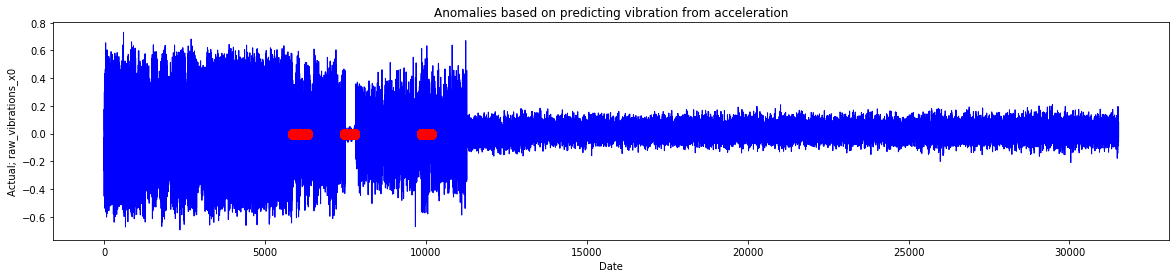

In [138]:
npic = 1
fig, ax[0] = plt.subplots(npic, 1, figsize=(20,npic * 4))
ax[0].plot(chan.y_test[:,0], lw=1, color='blue')

#ax.scatter(x_axis, temp_sal_high, lw=8, color='red')
for asc in errors.anom_scores:
    x_axis = np.arange(asc['start_idx'],asc['end_idx'],1)
    y_axis = np.zeros(asc['end_idx'] - asc['start_idx'])
    ax[0].scatter(x_axis,y_axis, lw=5, color='red', zorder=10)
    
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Actual; raw_vibrations_x0')
ax[0].set_title('Anomalies based on predicting vibration from acceleration')
#ax[1].plot(chan.test[:,0], lw=1, color='blue')
#ax[1].set_xlabel('Date')
#ax[1].set_ylabel('Compare with raw training data')

#### What about other approaches ?

Gradient boosting based on sklearn took much longer and considerably more memory to train even after I reduced the amount of data by limiting it to a few days. 